## More realistic cost estimation using instances start/end times

In [232]:
from datetime import datetime, timedelta
import boto3
import pandas as pd
import json
from datetime import datetime
from collections import defaultdict
import time


#### parameters

start_time = datetime(2023, 12, 22, 16, 50)
end_time = datetime(2023, 12, 23, 10, 59)
recalculate_times = True  # activate this if you want to recalculate 
instances_types = ["c5."]
###

client = boto3.client('cloudtrail')

def get_ec2_events(event_name, start_time, end_time):
    events = []
    next_token = None  # Initialize the NextToken variable
    while True:  # Continue looping until break is called
        params = {
            "LookupAttributes": [
                {   'AttributeKey': 'EventName',
                    'AttributeValue': event_name, }, ],
            "MaxResults": 50,
            "StartTime": start_time,
            "EndTime": end_time,
        }
        if next_token:
            params["NextToken"] = next_token  # Only include NextToken if it's not None or empty
        response = client.lookup_events(**params)
        #print(response)
        for event in response['Events']:
            events += [event]
        next_token = response.get('NextToken')  # Get the NextToken from the response
        if not next_token:
            break  # Exit the loop if there is no 
    return events
    
def get_termination_times(terminate_instances):
    termination_times = defaultdict(list)
    for log in terminate_instances:
        cloud_trail_event = json.loads(log['CloudTrailEvent'])
        # Extracting instance details
        instance_id = cloud_trail_event['requestParameters']['instancesSet']['items'][0]['instanceId']
        termination_time = datetime.strptime(cloud_trail_event['eventTime'], '%Y-%m-%dT%H:%M:%SZ')
        termination_times[instance_id].append(termination_time)
    return termination_times
    
def get_creation_times(run_instances):
    creation_times = defaultdict(list)
    for log in run_instances:
        cloud_trail_event = json.loads(log['CloudTrailEvent'])
        if cloud_trail_event.get('responseElements') and cloud_trail_event['responseElements'].get('instancesSet'):
            items = cloud_trail_event['responseElements']['instancesSet'].get('items', [])
            for item in items:
                # Extracting instance details
                instance_id = item.get('instanceId')
                creation_time_str = str(item.get('launchTime'))
                instance_type = item.get('instanceType')
                if instance_id and creation_time_str:
                    if isinstance(creation_time_str, (int, str)) and creation_time_str.isdigit():
                        creation_time = datetime.utcfromtimestamp(int(creation_time_str) / 1000)
                    else:
                        print(f'Unexpected format for launchTime: {creation_time_str}')
                        continue  # Skip to the next iteration
                    creation_times[instance_id].append((creation_time, instance_type))
    return creation_times


def get_registration_times(register_events):
    registration_times = defaultdict(list)
    for event in register_events:
        cloud_trail_event = json.loads(event['CloudTrailEvent'])
        if 'responseElements' not in cloud_trail_event: continue
        if cloud_trail_event['responseElements'] is None: continue
        if 'containerInstance' not in cloud_trail_event['responseElements']: continue
        instance_id = cloud_trail_event['responseElements']['containerInstance']['ec2InstanceId']
        instance_identity_document = json.loads(cloud_trail_event['requestParameters']['instanceIdentityDocument'])
        instance_type = instance_identity_document.get('instanceType')
        # The registeredAt field might be used as the creation time
        reg_time_str = cloud_trail_event['responseElements']['containerInstance'].get('registeredAt')
        if reg_time_str.isdigit():
            reg_time =  datetime.utcfromtimestamp(int(reg_time_str) / 1000)
        else:
            reg_time = datetime.strptime(reg_time_str, '%b %d, %Y, %I:%M:%S %p')
        #reg_time = reg_time.replace(tzinfo=timezone.utc)
        if reg_time < start_time: continue
        registration_times[instance_id].append((reg_time, instance_type))
    return registration_times

def get_deregistration_times(deregister_events):
    deregistration_times = defaultdict(list)
    for event in deregister_events:
        cloud_trail_event = json.loads(event['CloudTrailEvent'])
        if 'responseElements' not in cloud_trail_event: continue
        if cloud_trail_event['responseElements'] is None: continue
        if 'containerInstance' not in cloud_trail_event['responseElements']: continue
        instance_id = cloud_trail_event['responseElements']['containerInstance']['ec2InstanceId']
        dereg_time_str = cloud_trail_event.get('eventTime')
        dereg_time = datetime.strptime(dereg_time_str, '%Y-%m-%dT%H:%M:%SZ') if dereg_time_str else None
        #dereg_time = dereg_time.replace(tzinfo=timezone.utc)
        deregistration_times[instance_id].append(dereg_time)
    return deregistration_times


if recalculate_times:
    # doesn't seem to work for creation_times, one time I couldn't find a RunInstances for the corresponding TerminateInstances. Maybe autoscaling group shenanigans
    #creation_times    = get_creation_times(   get_ec2_events('RunInstances',       start_time, end_time))
    #termination_times = get_termination_times(get_ec2_events('TerminateInstances', start_time, end_time))
    register_events   = get_ec2_events('RegisterContainerInstance',   start_time, end_time)
    deregister_events = get_ec2_events('DeregisterContainerInstance', start_time, end_time) 
registration_times   = get_registration_times  (register_events)
deregistration_times = get_deregistration_times(deregister_events)


#print(len(creation_times), "creations", len(termination_times), "terminations")
print(len(registration_times), "registrations", len(deregistration_times), "deregistrations")

aws_pricing = { # per hour
    'c5.metal': 1.6481,
    'c5.24xlarge': 1.4720,
    'c5.18xlarge': 1.2079,
    'c5.12xlarge': 0.8432,
    'c5.9xlarge': 0.6171,
    'c5.4xlarge': 0.2983,

    # d's
    'c5d.metal': 1.7126,
    'c5d.24xlarge': 1.7644,
    'c5d.18xlarge': 1.3264,
    'c5d.12xlarge': 0.9460,
    'c5d.9xlarge': 0.6978,
    'c5d.4xlarge': 0.3633,
    'c5d.large': 0, # don't care, shouldn't have
    'c5d.xlarge': 0, # don't care, shouldn't have
}

def calculate_cost(instance_type, duration):
    duration_hours = duration.total_seconds() / 3600
    hourly_rate = aws_pricing[instance_type]
    return hourly_rate * duration_hours

def populate_data(start_times, end_times, start_label="Registration time", end_label="Deregistration time", instances_type = "c5."):
    columns = ['Instance ID', 'Instance Type', start_label, end_label, 'Duration (HH:MM:SS)', 'Cost (USD)']
    # Instead of appending to df in a loop, accumulate data in a list
    instance_data_list = []
    for instance_id, data in start_times.items():
        if instance_id in end_times:
            creation_time, instance_type = data[0]
            termination_time = end_times[instance_id][0]
            if instances_type not in instance_type:
                continue
            if creation_time < termination_time:
                duration = termination_time - creation_time
                cost = calculate_cost(instance_type, duration)
                instance_data_list.append({
                    'Instance ID': instance_id,
                    'Instance Type': instance_type,
                    start_label: creation_time,
                    end_label: termination_time,
                    'Duration (HH:MM:SS)': str(duration),
                    'Cost (USD)': cost
                })
    return instance_data_list, columns


for instance_type in instances_types:
    print("instance type:", instances_type)
    instance_data_list, columns  = populate_data(registration_times, deregistration_times, "Registration time", "Deregistration time", instances_type)
    #instances_data_list = populate_data(creation_times, termination_times, "Creation Time", "Termination Time", "c5.")

    df = pd.DataFrame(instance_data_list, columns=columns)
    df_sorted = df.sort_values(by='Registration time')
    print(df_sorted)

    print(f"Total EC2 instance cost for time period {start_time} to {end_time}:")
    print(f"{df['Cost (USD)'].sum():.2f}$")

19253 registrations 19232 deregistrations
instance type: c5.
               Instance ID Instance Type   Registration time  \
19231  i-0dfbdd1d63a4a2161    c5.4xlarge 2023-12-22 16:51:07   
19230  i-0d4c73ec78e5ac9a4    c5.4xlarge 2023-12-22 16:51:07   
19228  i-007a822da1cd2a7f4    c5.4xlarge 2023-12-22 16:51:08   
19229  i-07e6c94bc1f9541b2    c5.4xlarge 2023-12-22 16:51:08   
19226  i-0490986205d111971    c5.4xlarge 2023-12-22 16:51:09   
...                    ...           ...                 ...   
4      i-0645a70912c174b97      c5.metal 2023-12-22 18:14:50   
3      i-0c2f275157d180577      c5.metal 2023-12-22 18:14:52   
2      i-09d90e931d6e9b6f3   c5.18xlarge 2023-12-22 18:14:57   
1      i-08e9bef80e40ae897   c5.18xlarge 2023-12-22 18:15:07   
0      i-0d173e7de48ea9d86      c5.metal 2023-12-22 18:15:15   

      Deregistration time Duration (HH:MM:SS)  Cost (USD)  
19231 2023-12-22 19:08:07             2:17:00    0.681118  
19230 2023-12-22 19:52:18             3:01:11    0

## Instances statistics

In [252]:
def sort_by_instance_type(instance_series,value):
    # Convert the Series into a DataFrame
    df = instance_series.reset_index()
    df.columns = ['Instance Type', value]

    # Extract and sort by size (putting 'c5.metal' at the end)
    df['Size'] = df['Instance Type'].apply(lambda x: int(x.split('.')[1].replace('xlarge', '')) if 'xlarge' in x else float('inf'))
    sorted_df = df.sort_values(by='Size')

    # Drop the Size column as it is no longer needed
    sorted_df = sorted_df.drop(columns=['Size'])
    return sorted_df.to_string(index=False)
    
# Count the number of instances per instance type
instance_counts = df['Instance Type'].value_counts()
print(sort_by_instance_type(instance_counts,'Count'))

# Convert Duration to timedelta for calculation
df['Duration'] = pd.to_timedelta(df['Duration (HH:MM:SS)'])
# Calculate average instance running time per instance type
average_durations = df.groupby('Instance Type')['Duration'].mean()
adc = average_durations.dt.components
adc['hours'] = adc['hours'].astype(str).str.zfill(2)
adc['minutes'] = adc['minutes'].astype(str).str.zfill(2)
adc['seconds'] = adc['seconds'].astype(str).str.zfill(2)
average_durations_formatted = adc['hours'] + ':' + adc['minutes'] + ':' + adc['seconds']
print(sort_by_instance_type(average_durations_formatted,'Duration (HH:MM:SS)'))

# Calculate cumulative cost per instance type
cumulative_cost_per_type = df.groupby('Instance Type')['Cost (USD)'].sum()
print(sort_by_instance_type(cumulative_cost_per_type,'Cost'))

Instance Type  Count
   c5.4xlarge  16155
   c5.9xlarge    367
  c5.12xlarge   1382
  c5.18xlarge   1251
  c5.24xlarge      7
     c5.metal     70
Instance Type Duration (HH:MM:SS)
   c5.4xlarge            01:52:11
   c5.9xlarge            02:24:25
  c5.12xlarge            02:35:25
  c5.18xlarge            03:13:55
  c5.24xlarge            03:44:55
     c5.metal            03:06:48
Instance Type        Cost
   c5.4xlarge 9011.108380
   c5.9xlarge  545.167567
  c5.12xlarge 3018.536078
  c5.18xlarge 4883.970853
  c5.24xlarge   38.625689
     c5.metal  359.190576


## Get cumulative EBS size

In [175]:
# Instance types and their vCPUs
instance_vcpus = {
    'c5.4xlarge': 16,
    'c5.9xlarge': 36,
    'c5.12xlarge': 48,
    'c5.18xlarge': 72,
    'c5.24xlarge': 96,
    'c5.metal': 96
}

# Ensure 'Duration' is in timedelta format
df['Duration'] = pd.to_timedelta(df['Duration (HH:MM:SS)'])

# Calculate EBS size for each instance
df['EBS Size (GB)'] = df['Instance Type'].apply(lambda x: instance_vcpus.get(x, 0) * 20)

# Calculate duration in hours
df['Duration (Hours)'] = df['Duration'].dt.total_seconds() / 3600

# Calculate EBS GB hours for each instance
df['EBS GB Hours'] = df['EBS Size (GB)'] * df['Duration (Hours)']

# Calculate cumulative EBS GB hours
cumulative_ebs_gb_hours = df['EBS GB Hours'].sum()

print("Cumulative EBS GB Hours:", cumulative_ebs_gb_hours)

# Convert EBS GB hours to GB-months
gb_hours_to_gb_months = lambda gb_hours: gb_hours / 720

# Cumulative EBS GB hours (from previous calculation)
cumulative_ebs_gb_hours = df['EBS GB Hours'].sum()

# Convert to GB-months
cumulative_ebs_gb_months = gb_hours_to_gb_months(cumulative_ebs_gb_hours)

# Cost rate per GB-month
cost_per_gb_month = 0.08

# Calculate total cost
total_cost = cumulative_ebs_gb_months * cost_per_gb_month

print("Estimated EBS Cost: ${:.2f}".format(total_cost))

Cumulative EBS GB Hours: 2011472.6444444444
Estimated EBS Cost: $223.50


## Checking one instance running time

In [140]:
df.loc[df['Instance ID'] == 'i-04258055b46a409d1']

Empty DataFrame
Columns: [Instance ID, Instance Type, Creation Time, Termination Time, Duration (HH:MM:SS), Cost (USD)]
Index: []

## Cross-check jobs (only those that succeeded) for a particular instance in DynamoDB

In [127]:
import boto3
from boto3.dynamodb.conditions import Attr

# Initialize a DynamoDB client
dynamodb = boto3.resource('dynamodb')

# Specify your DynamoDB table
table = dynamodb.Table('Logan')

# Specify the instance ID you want to filter
instance_id = 'i-0f2e9bae356a36f38'  # Replace with your instance ID


# Initialize the scan parameters
scan_kwargs = {
    'FilterExpression': Attr('x64_instance_id').eq(instance_id)
}

# Initialize an empty list to collect all results
jobs_on_instance = []

# Paginate through results
while True:
    response = table.scan(**scan_kwargs)
    jobs_on_instance.extend(response.get('Items', []))

    # Check if there are more items to retrieve
    if 'LastEvaluatedKey' not in response:
        break

    # Set the ExclusiveStartKey for the next scan
    scan_kwargs['ExclusiveStartKey'] = response['LastEvaluatedKey']

# Print the results
for job in jobs_on_instance:
    print(job['accession'],job['x64_processing_time'])

KeyboardInterrupt: 

## Scan dynamodb and find max wait time ratio over input size


In [121]:
import boto3

# Initialize the DynamoDB client
dynamodb = boto3.resource('dynamodb')

# Specify the table name
table_name = 'Logan'

# Access the DynamoDB table
table = dynamodb.Table(table_name)

# Scan the table
response = table.scan()

large_ratios = []
ratios = []
wait_times = []
small_wait_times = []
threshold = 10000 # only examine ratio for datasets above that MB

def process_item(item):
    global large_ratios,ratios,wait_times,small_wait_times
    accession = item['accession']
    if 'cuttlefisha_x64_max_wait' in item and 'reads_sra_size' in item and float(item['reads_sra_size']) != 0:
        dataset_mbases = int(int(item['reads_sra_size']) / (1024*1024))
        if dataset_mbases > threshold:
            ratio = ((float(item['cuttlefisha_x64_max_wait']) / dataset_mbases), dataset_mbases)
            large_ratios.append(ratio)
        else:
            small_wait_times += [(float(item['cuttlefisha_x64_max_wait']), dataset_mbases, accession)]
        if dataset_mbases > 0:
            wait_times += [(float(item['cuttlefisha_x64_max_wait']), dataset_mbases, accession)]
            ratio = ((float(item['cuttlefisha_x64_max_wait']) / dataset_mbases), dataset_mbases)
            ratios.append(ratio)

# Iterate over the items in the response
for item in response.get('Items', []):
    process_item(item)

# Handle potential pagination if the scan result is large
while 'LastEvaluatedKey' in response:
    response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
    for item in response.get('Items', []):
        process_item(item)


# Calculate and print the maximum and mean ratios
if ratios:
    max_ratio = max(large_ratios)
    mean_ratio = sum([x[0] for x in large_ratios]) / len(large_ratios)
    print(f"Maximum ratio for >{threshold} MB datasets; dataset MBases:", max_ratio)
    print(f"Mean ratio for >{threshold} MB datasets:", mean_ratio)
    print(f"Maximum wait time, <{threshold} MB datasets; dataset MBases:", max(small_wait_times))
    print("")
    max_ratio = max(ratios)
    mean_ratio = sum([x[0] for x in ratios]) / len(ratios)
    print(f"Maximum ratio for everything; dataset MBases:", max_ratio)
    print(f"Mean ratio for everything:", mean_ratio)
    print(f"Maximum wait time, everything; dataset MBases:", max(wait_times))
    
else:
    print("No valid ratios found.")


Maximum ratio for >10000 MB datasets; dataset MBases: (0.15172062085014193, 12091)
Mean ratio for >10000 MB datasets: 0.03902129041532995
Maximum wait time, <10000 MB datasets; dataset MBases: (938.6913101673126, 4172, 'ERR6336510')

Maximum ratio for everything; dataset MBases: (189.8120837211609, 1)
Mean ratio for everything: 1.9890345331833015
Maximum wait time, everything; dataset MBases: (1834.4540266990662, 12091, 'SRR22198295')


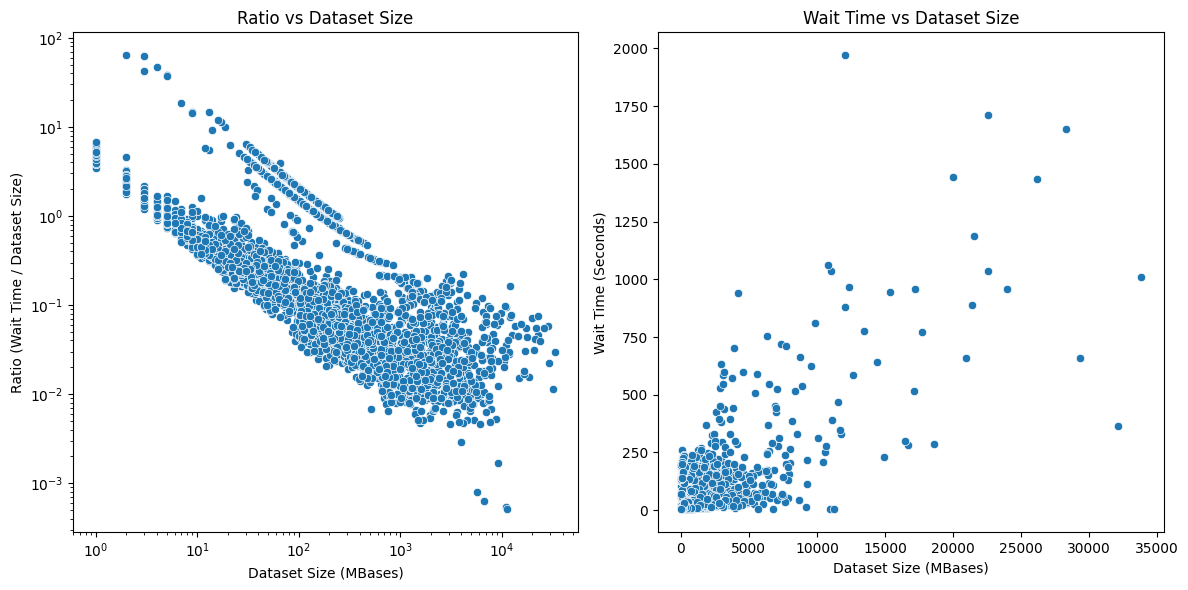

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming large_ratios, ratios, wait_times, small_wait_times are already defined and populated

# Convert arrays to DataFrame for easier plotting
df_ratios = pd.DataFrame(ratios, columns=['Ratio', 'Dataset Size (MBases)'])
df_wait_times = pd.DataFrame(wait_times, columns=['Wait Time (Seconds)', 'Dataset Size (MBases)', 'Accession'])

# Plotting
plt.figure(figsize=(12, 6))

# Plot for Ratios vs Dataset Size
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_ratios, x='Dataset Size (MBases)', y='Ratio')
plt.title('Ratio vs Dataset Size')
plt.xlabel('Dataset Size (MBases)')
plt.ylabel('Ratio (Wait Time / Dataset Size)')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xscale('log')  

# Plot for Wait Times vs Dataset Size
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_wait_times, x='Dataset Size (MBases)', y='Wait Time (Seconds)')
plt.title('Wait Time vs Dataset Size')
plt.xlabel('Dataset Size (MBases)')
plt.ylabel('Wait Time (Seconds)')
#plt.xscale('log') 
#plt.yscale('log') 

plt.tight_layout()
plt.show()